In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
import sklearn 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv(os.path.join('Stocks', 'hpq.us.txt'), delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close'])
print('Loaded Data Successfully')

Loaded Data Successfully


In [4]:
df.head(10)

,Date,Open,High,Low,Close
0,1970-01-02,0.30627,0.30627,0.30627,0.30627
1,1970-01-05,0.30627,0.31768,0.30627,0.31385
2,1970-01-06,0.31385,0.31385,0.30996,0.30996
3,1970-01-07,0.31385,0.31385,0.31385,0.31385
4,1970-01-08,0.31385,0.31768,0.31385,0.31385
5,1970-01-09,0.31385,0.31768,0.31385,0.31768
6,1970-01-12,0.31768,0.32534,0.31768,0.32534
7,1970-01-13,0.32534,0.32916,0.32152,0.32152
8,1970-01-14,0.32152,0.32534,0.31768,0.32152
9,1970-01-15,0.32152,0.32916,0.32152,0.32916


In [5]:
df = df.sort_values('Date')
df.head(10)

,Date,Open,High,Low,Close
0,1970-01-02,0.30627,0.30627,0.30627,0.30627
1,1970-01-05,0.30627,0.31768,0.30627,0.31385
2,1970-01-06,0.31385,0.31385,0.30996,0.30996
3,1970-01-07,0.31385,0.31385,0.31385,0.31385
4,1970-01-08,0.31385,0.31768,0.31385,0.31385
5,1970-01-09,0.31385,0.31768,0.31385,0.31768
6,1970-01-12,0.31768,0.32534,0.31768,0.32534
7,1970-01-13,0.32534,0.32916,0.32152,0.32152
8,1970-01-14,0.32152,0.32534,0.31768,0.32152
9,1970-01-15,0.32152,0.32916,0.32152,0.32916


Text(0, 0.5, 'Mid Price')

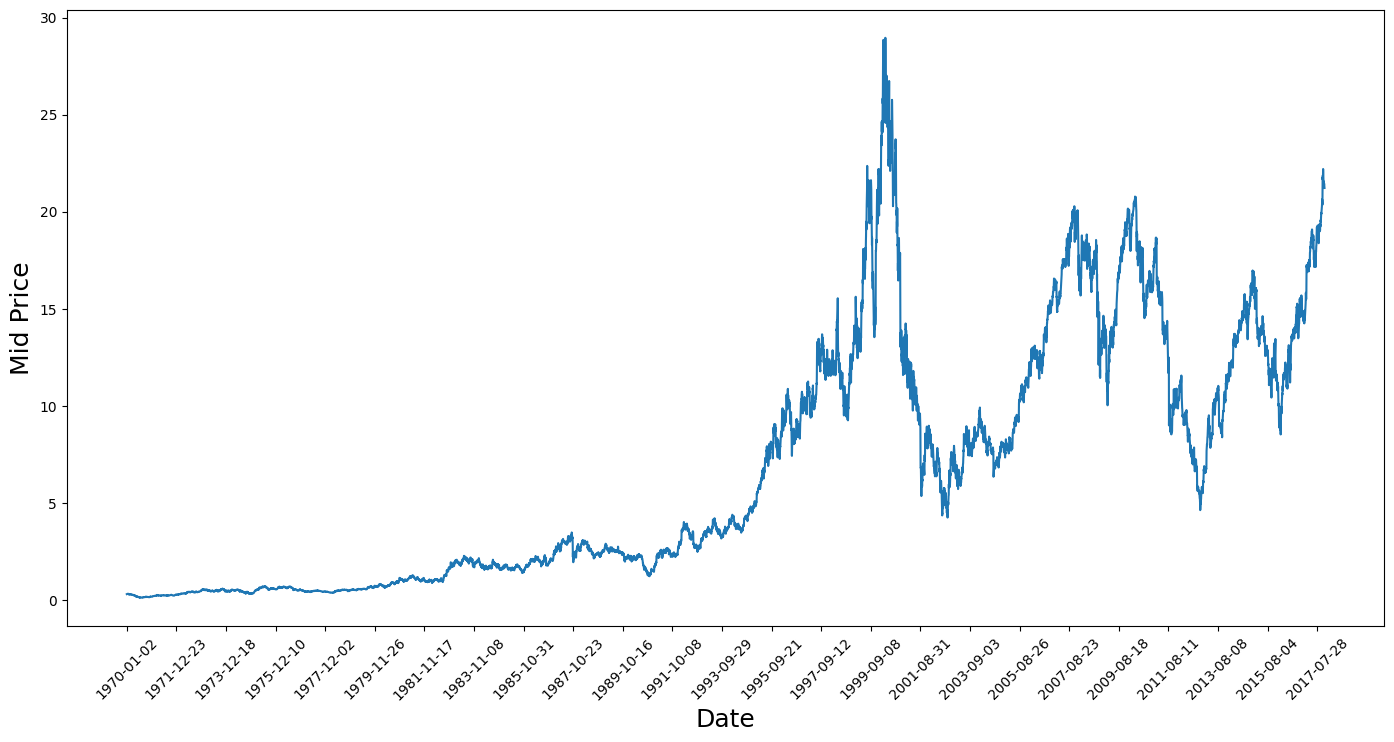

In [6]:
plt.figure(figsize=(17, 8))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0, df.shape[0],500), df['Date'].loc[::500], rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Mid Price', fontsize=18)

In [7]:
from sklearn.preprocessing import MinMaxScaler
price = df[['Close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
price.loc[:, 'Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

In [8]:
price.head(5)

,Close
0,-0.987126
1,-0.986616
2,-0.986878
3,-0.986616
4,-0.986616


In [9]:
def split_data(stock, lookback):
    raw = stock.to_numpy()
    data = []

    for i in range(len(raw) - lookback):
        data.append(raw[i: i + lookback])

    data = np.array(data)
    test_size = int(np.round(0.2*data.shape[0]))
    train_size = data.shape[0] - (test_size)

    X_train = data[:train_size,:-1,:]
    y_train = data[:train_size,-1,:] 

    X_test = data[train_size:, :-1] 
    y_test = data[train_size:,-1,:] 

    return [X_train, y_train, X_test, y_test] 

In [10]:
lookback = 20
X_train, y_train, X_test, y_test = split_data(price, lookback)

In [11]:
import torch #NOTE: Check requirement for pytorch command (CPU/GPU)
import torch.nn as nn

In [12]:
X_train = torch.from_numpy(X_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)

X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [13]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
epochs = 41

In [14]:
# Implementing LSTM Class

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out


In [15]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [16]:
import time 

hist = np.zeros(epochs)
start_time = time.time()
lstm = []

for t in range(epochs):
    y_train_pred = model(X_train)
    loss = criterion(y_train_pred, y_train)
    print("Epoch: ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

train_time = time.time() - start_time
print("Training Time: {}", format(train_time))


Epoch:  0 MSE:  0.5856918692588806
Epoch:  1 MSE:  0.4109705984592438
Epoch:  2 MSE:  0.22783808410167694
Epoch:  3 MSE:  0.11331582814455032
Epoch:  4 MSE:  0.23749159276485443
Epoch:  5 MSE:  0.12233494222164154
Epoch:  6 MSE:  0.10280616581439972
Epoch:  7 MSE:  0.12502382695674896
Epoch:  8 MSE:  0.13686397671699524
Epoch:  9 MSE:  0.13038912415504456
Epoch:  10 MSE:  0.11032885313034058
Epoch:  11 MSE:  0.08504965156316757
Epoch:  12 MSE:  0.06540005654096603
Epoch:  13 MSE:  0.060155633836984634
Epoch:  14 MSE:  0.0633552223443985
Epoch:  15 MSE:  0.05404176563024521
Epoch:  16 MSE:  0.027941124513745308
Epoch:  17 MSE:  0.006410910747945309
Epoch:  18 MSE:  0.014144089072942734
Epoch:  19 MSE:  0.035121940076351166
Epoch:  20 MSE:  0.028712762519717216
Epoch:  21 MSE:  0.012206651270389557
Epoch:  22 MSE:  0.005082887597382069
Epoch:  23 MSE:  0.008160386234521866
Epoch:  24 MSE:  0.01276400312781334
Epoch:  25 MSE:  0.013116918504238129
Epoch:  26 MSE:  0.01073715090751648
Epoc

In [17]:
predict = pd.DataFrame(scaler.inverse_transform(y_test.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().numpy()))

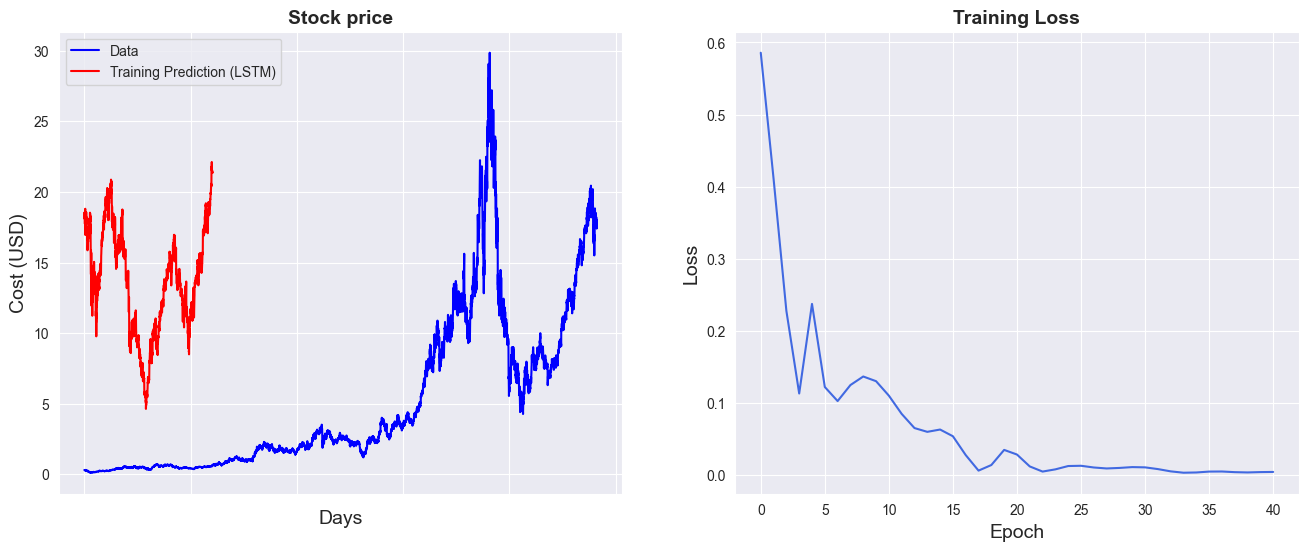

In [18]:
import seaborn as sns
sns.set_style("darkgrid")

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1,2,1)
ax=sns.lineplot(x=original.index, y=original[0], label="Data", color='blue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='red')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)


In [24]:
y_test_pred = model(X_test)

# y_train_pred = scaler.inverse_transform(y_train_pred)
# y_train = scaler.inverse_transform(y_train)
# y_test_pred = scaler.inverse_transform(y_test_pred)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train)
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test)



train_score = math.sqrt(mean_squared_error(y_train[:, 0], y_train_pred[:,0]))
print("Train score: %.2f RMSE" % (train_score))

test_score = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print("Test score: %.2f RMSE" % (test_score))

lstm.append(train_score)
lstm.append(test_score)
lstm.append(train_time)

Train score: 1.01 RMSE
Test score: 1.28 RMSE


In [27]:
torch.save(model, './stocks.pt')